### Intro

This notebook looks into application of gradient calculation to finding best parameter update, i.e. an application close to the problem of neural networks training.

Plan:

- Define a loss function for classification task
- Use a toy example of a single datapoint and a single weight vector to train gradient calculation
- Calculate gradient on the loss function in respect to weights using three appraches:
   - Manual calculation
   - Adapt the custom autograd code to support more operations
   - Use Tensorflow


In [255]:
import numpy as np
import tensorflow as tf
import os
from typing import List
import math

# Surpress warnings from tensorflow
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

### Loss function

Measure of our happiness with performance of the neural network. It is a mathematical function that is used to measure the difference between the predicted output of the neural network and the actual output, also known as the ground truth. The goal of training a neural network is to minimise the value of the loss function, as this indicates that the network is making accurate predictions.

Most popular loss functions:

- *SVM* - computes uncalibrated scores for each class
- *Cross-entropy* - computes scores which could be interpreted as normalised probabilites (using softmax activation)

In both cases, loss functions output a scalar value of *loss* and average it over all examples in the training set.

In this example, let's implement cross-entropy loss i.e. a loss function on normalised scores.

The following components are in play:

* data input `x` 
* weights of the model `W`
* output data `y`
* linear transformation (dot product) `dot(x, W)` producing `scores`
* output layer activation function `activation(scores)`, producing `normalised_scores` - this is required for the cross-entropy loss
* loss function `loss(scores, y)`


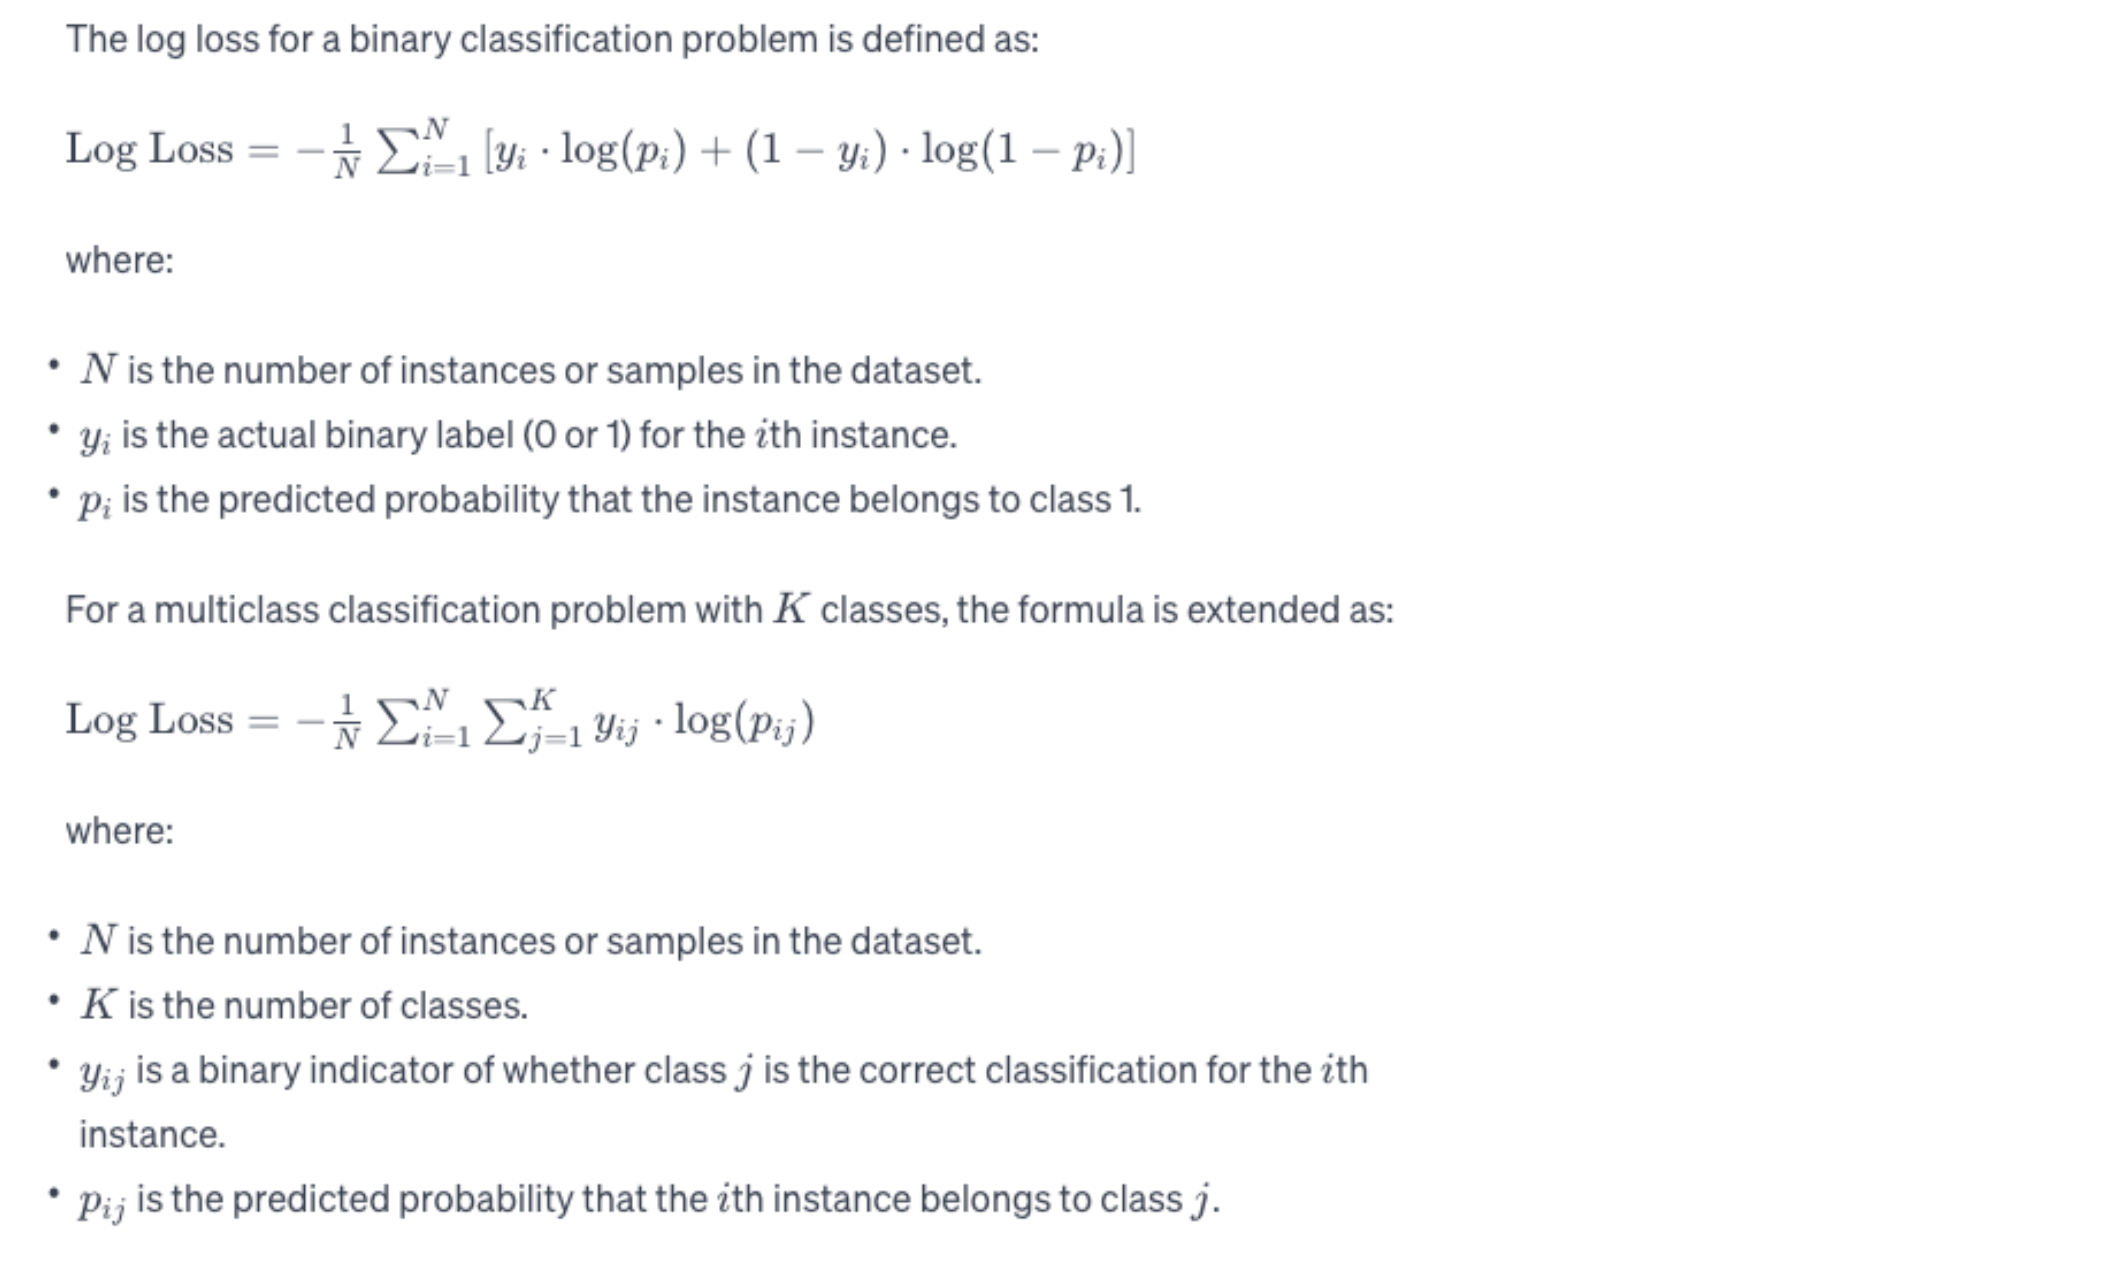

### Single example data point - manual gradient calculation

Classification problem: assume x vector with 2 dimensions and some weights for calculating score of the correct class (in this example)

In [261]:
# 2-dim x
x = [-1, -2]

# weights + bias
w = [2, -3, -3]

# Stages of cross-entropy loss calculation:

# (1) unnormalised score (logits) - simple dot product
z = x[0] * w[0] + x[1] * w[1] + w[2]
print('Score:', z)

# (2) normalised score

def sigmoid(z):
    return 1 / (1 + math.exp(-z))

normalised_score = sigmoid(z)

print('P(correct class): ', normalised_score)

# (3) loss function: negative log of probability being the correct class
loss = -np.log(normalised_score)
print('Loss: ', loss)

Score: 1
P(correct class):  0.7310585786300049
Loss:  0.3132616875182228


In [274]:
# df/dx (ln x) = 1 / x
dloss_dz = - 1 / normalised_score
dsigm_dz = ((1 - normalised_score) * normalised_score) * dloss_dz

df_dw = [x[0] * dsigm_dz, x[1] * dsigm_dz, 1.0 * dsigm_dz]
print(df_dw)

[0.2689414213699951, 0.5378828427399902, -0.2689414213699951]


### Computation of the gradient using the custom autograd engine

Number of operations was expended and some logic changed to allow kwargs in order to accomodate the binary cross-entropy function

In [269]:
class ComputeNode():
    def __init__(self, left_input=None, right_input=None, value=None, operation=None, **kwargs):
        """
        operation=None means it is a head node of the graph
        
        """
        # Ensures all operation-specific variables are instantiated
        for k, v in kwargs.items():
            setattr(self, k, v)

        if left_input is None and right_input is None and value is None:
            raise ValueError('Value is N/A and operation is N/A - error in setup of the Node')
        self.left_input = left_input
        self.right_input = right_input
        
        if left_input is not None:
            self.left_input.next = self
        if right_input is not None:
            self.right_input.next = self
        
        self.operation = operation
        self.value = value
        
        self.next = None
        self.gradient = None


    def __repr__(self):
        if self.operation:
            return f'ComputeNode: [{self.operation.symbol}]'
        else:
            return f'ComputeNode: [{self.value}]'

    def compute_value(self):
        if self.value is not None:
            print('Value is alrady calculated for this node')
        elif self.operation:
            self.value = self.operation.compute(self.left_input, self.right_input, **vars(self))
        else:
            raise ValueError('Value is N/A and operation is N/A - error in setup of the Node')

    def get_value(self):
        if self.value is None:
            self.compute_value()
        return self.value

    def compute_gradient(self):
        # Gradient of the final node is equal to 1
        if self.next is None:
            self.gradient = 1
        else:
            op = self.next.operation
            # getting another node (could be None)
            other = self.next.get_other_input(self)
            # application of chain rule: df/dx = df/dg * dg/dx
            self.gradient = op.partial_derivative(input_node=self, other_node=other, **vars(self.next)) * self.next.get_gradient()

    def get_gradient(self):
        if self.gradient is None:
            self.compute_gradient()
        return self.gradient

    def get_other_input(self, node):
        if node == self.left_input:
            return self.right_input
        else:
            return self.left_input


In [276]:
class AdditionOperation():
    symbol = '+'
    def compute(input_node: ComputeNode, other_node: ComputeNode, **kwargs) -> float:
        """
        Arguments:
        
        input_node : the input with respect to which partial derivative is be calculated
        other_node : the 'other' input node in the current computational
        node, which gradient we want to compute
        """
        out = input_node.get_value() + other_node.get_value()
        return out

    def partial_derivative(input_node: ComputeNode, other_node: ComputeNode, **kwargs):
        return 1

class MultiplicationOperation():
    symbol = '*'
    def compute(input_node: ComputeNode, other_node: ComputeNode, **kwargs) -> float:
        out = input_node.get_value() * other_node.get_value()
        return out

    def partial_derivative(input_node: ComputeNode, other_node: ComputeNode, **kwargs):
        return other_node.value

class ExpOperation():
    symbol = 'exp'
    def compute(input_node: ComputeNode, other_node: ComputeNode, **kwargs) -> float:
        out = math.exp(input_node.get_value())
        return out

    def partial_derivative(input_node: ComputeNode, other_node: ComputeNode, **kwargs):
        return math.exp(input_node.get_value())


class InverseOperation():
    symbol = '1/x'
    def compute(input_node: ComputeNode, other_node: ComputeNode, **kwargs) -> float:
        out = 1 / input_node.get_value()
        return out

    def partial_derivative(input_node: ComputeNode, other_node: ComputeNode, **kwargs):
        """
        other_node - the 'other' input node in the current computational
        node, which gradient we want to compute
        """
        return -1 / pow(input_node.get_value(), 2)


class ScalingOperation():
    symbol = 'ax'
    def compute(input_node: ComputeNode, other_node: ComputeNode, **kwargs) -> float:
        scaler = kwargs.get('scaler')
        out = scaler * input_node.get_value()
        return out

    def partial_derivative(input_node: ComputeNode, other_node: ComputeNode, **kwargs):
        scaler = kwargs.get('scaler')
        return scaler

class AddConstantOperation():
    symbol = 'x + c'
    def compute(input_node: ComputeNode, other_node: ComputeNode, **kwargs) -> float:
        constant = kwargs.get('constant')
        out = constant + input_node.get_value()
        return out

    def partial_derivative(input_node: ComputeNode, other_node: ComputeNode, **kwargs):
        return 1

class LogOperation():
    symbol = 'log'
    def compute(input_node: ComputeNode, other_node: ComputeNode, **kwargs) -> float:
        out = math.log(input_node.get_value())
        return out

    def partial_derivative(input_node: ComputeNode, other_node: ComputeNode, **kwargs):
        return 1 / input_node.get_value()

In [271]:
class ComputationalGraph:
    def __init__(self, root: List[ComputeNode], leaf: ComputeNode):
        # root can be one or several nodes
        self.root = root
        self.leaf = leaf


    def forward_pass(self):
        """
        Calculates forward pass of the computational graph,
        i.e. get value of the function.
        """
        return self.leaf.get_value()

    def backprop(self):
        """
        Get gradient vector in respect to the inputs
        through backpropagation
        """
        self.forward_pass()
        out = [n.get_gradient() for n in self.root]
        return out

In [265]:
math.log(2.718281828459045)

1.0

In [277]:
# x
x0 = ComputeNode(value=-1)
x1 = ComputeNode(value=-2)

# w
w0 = ComputeNode(value=2)
w1 = ComputeNode(value=-3)
w2 = ComputeNode(value=-3)

# score (dot product)
xw0 = ComputeNode(left_input=x0, right_input=w0, operation=MultiplicationOperation)
xw1 = ComputeNode(left_input=x1, right_input=w1, operation=MultiplicationOperation)
xw0_xw1 = ComputeNode(left_input=xw0, right_input=xw1, operation=AdditionOperation)
score =  ComputeNode(left_input=xw0_xw1, right_input=w2, operation=AdditionOperation)

# normalised score (sigmoid): 1 / (1 + np.exp(-score))
minus_score = ComputeNode(left_input=score, operation=ScalingOperation, scaler=-1)
exp_score = ComputeNode(left_input=minus_score, operation=ExpOperation)
one_plus_exp_score = ComputeNode(left_input=exp_score, operation=AddConstantOperation, constant=1)
sigmoid = ComputeNode(left_input=one_plus_exp_score, operation=InverseOperation)

# loss
exp_loss = ComputeNode(left_input=sigmoid, operation=LogOperation)
loss = ComputeNode(left_input=exp_loss, operation=ScalingOperation, scaler=-1)

# Computational Graph object
graph = ComputationalGraph(root=[w0, w1, w2], leaf=loss)

weights_grad = graph.backprop()
print('Results from computational graph object:')
print(weights_grad)
print('Custom autograd results match results of manual calculation:', np.allclose(df_dw, weights_grad))

Results from computational graph object:
[0.26894142136999516, 0.5378828427399903, -0.26894142136999516]
Custom autograd results match results of manual calculation: True


### Same with Tensorflow

In [281]:
# x
x0 = tf.Variable(-1.0)
x1 = tf.Variable(-2.0)

# w
w0 = tf.Variable(2.0)
w1 = tf.Variable(-3.0)
w2 = tf.Variable(-3.0)

with tf.GradientTape(persistent=True) as tape:
    f = -tf.math.log(1 / (1 + tf.math.exp(-(x0 * w0 + x1 * w1 + w2))))
    df_dw0 = tape.gradient(f, w0)
    df_dw1 = tape.gradient(f, w1)
    df_dw2 = tape.gradient(f, w2)

# Print the results
print("df/dw0 =", df_dw0.numpy())
print("df/dw1 =", df_dw1.numpy())
print("df/dw2 =", df_dw2.numpy())
tf_results = [df_dw0.numpy(), df_dw1.numpy(), df_dw2.numpy()]
print('Custom autograd results match results of tensorflow:', np.allclose(weights_grad, tf_results))

del tape

df/dw0 = 0.2689414
df/dw1 = 0.5378828
df/dw2 = -0.2689414
Custom autograd results match results of tensorflow: True


In [286]:
# Here is another way to achieve this, now moving to vectorised operations
x = tf.constant([[-1.0, -2.0]])
w = tf.Variable([[2.0, -3.0]])
b = tf.Variable(-3.0)
y_true = tf.constant([1.0])

with tf.GradientTape(persistent=True) as tape:
    # Forward pass
    logits = tf.matmul(x, tf.transpose(w)) + b
    normalised_scores = -tf.math.log(1 / (1 + tf.exp(-logits)))

# Watch the variable b explicitly
tape.watch(b)

# Calculate gradients with respect to every trainable variable
grad_w = tape.gradient(normalised_scores, w)
grad_b = tape.gradient(normalised_scores, b)

print("Gradient with respect to w:", grad_w.numpy())
print("Gradient with respect to b:", grad_b.numpy())

# Release the resources associated with the persistent tape
del tape

Gradient with respect to w: [[0.2689414 0.5378828]]
Gradient with respect to b: -0.2689414


In [204]:
y_true = [1.0]
y_pred = [1.0]
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce(y_true, y_pred).numpy()

0.3132617

In [218]:
logits.numpy()

array([[0.7310586]], dtype=float32)

In [304]:
# Now doing the same but this time using the BinaryCrossentropy function from the framework
x = tf.constant([[-1.0, -2.0]])
w = tf.Variable([[2.0, -3.0]])
b = tf.Variable(-3.0)
y_true = tf.constant([1.0])

with tf.GradientTape(persistent=True) as tape:
  # Forward pass
    normalised_scores = 1 / (1 + tf.math.exp(-(tf.matmul(x, tf.transpose(w)) + b)))
    score = (tf.matmul(x, tf.transpose(w)) + b)
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = bce(y_true, score)

# Calculate gradients with respect to every trainable variable
grad_w = tape.gradient(loss, w)
grad_b = tape.gradient(loss, b)
print('Value of loss function:', loss.numpy())
print("Gradient with respect to w:", grad_w.numpy())
print("Gradient with respect to b:", grad_b.numpy())
tf_results = grad_w.numpy()[0].tolist() + [grad_b.numpy()]
print('Custom autograd results match results of tensorflow:', np.allclose(weights_grad, tf_results))
del tape

Value of loss function: 0.3132617
Gradient with respect to w: [[0.26894143 0.53788286]]
Gradient with respect to b: -0.26894143
Custom autograd results match results of tensorflow: True


### Conclusion

We looked into calculation of gradient specifically in the context of loss function (binary cross-entropy) on a single data point and a single vector of weights. This was done with manually, with a custom autograd engine and with Tensorflow.

Next step is to build on the knowledge from this to:
- Move towards a dataset with multiple examples
- Implement gradient descent algorithm as a training procedure
- Add second hidden layer

Next time the autograd will be moved to a separate file, it will use vectorised operations, and potentially some unit tests.